In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import combinations_with_replacement
from math import factorial

In [3]:
def generate_Y(n, degree, dim, X, terms, c_s, noise_Y):
    Y = np.zeros((n, 1))
    for i in range(n):
        x = X[i]
        y = 0
        for j in range(len(terms)):
            c = c_s[j]
            term = 1
            for k in terms[j]:
                if k == dim:
                    continue
                term *= x[k]
            y += c * term
        Y[i, 0] = y
    if noise_Y:
        Y = Y + np.random.randn(n, 1)
    return Y

def generate_data(n, degree, dim, x_range, c_range, noise_X=False, noise_Y=False):
    X = np.random.rand(n, dim) * x_range - (x_range / 2)
    terms = list(combinations_with_replacement(range(dim+1), degree))
    c_s = np.random.rand(len(terms)) * c_range - (c_range / 2)
    Y = generate_Y(n, degree, dim, X, terms, c_s, noise_Y)
    if noise_X:
        X = X + np.random.randn(n, dim)
    return X, Y, c_s

def generate_data_from_c(n, degree, dim, x_range, c_s, noise_X=False, noise_Y=False):
    X = np.random.rand(n, dim) * x_range - (x_range / 2)
    terms = list(combinations_with_replacement(range(dim+1), degree))
    Y = generate_Y(n, degree, dim, X, terms, c_s, noise_Y)
    if noise_X:
        X = X + np.random.randn(n, dim)
    return X, Y

In [11]:
degree = 3
dim = 1

n_train = 1000
n_test = 100
x_range = 20

c_range = 20

In [12]:
x_train, y_train, c_true = generate_data(n_train, degree, dim, x_range, c_range)
x_test, y_test = generate_data_from_c(n_test, degree, dim, x_range, c_true)

In [13]:
x_train[0], y_train[0], c_true

(array([-3.75062526]),
 array([ 395.80326238]),
 array([-5.91461389,  4.65367809, -6.57168675, -6.36835384]))

In [9]:
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

n_hidden_1 = 1
num_input = 1
num_output = 1

X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_output])

weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_output]))
}

In [15]:
def neural_net(x):
    layer_1 = tf.nn.relu(tf.matmul(x, weights['h1']))
    out_layer = tf.matmul(layer_1, weights['out'])
    return out_layer

In [16]:
predictions = neural_net(X)
loss = tf.losses.mean_squared_error(Y, predictions, reduction="none")
mse = tf.losses.mean_squared_error(Y, predictions)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [17]:
sess = tf.Session()
sess.run(init)

for step in range(num_steps):
    sess.run(train, feed_dict={X: x_train, Y: y_train})
    
    if (step + 1) % display_step == 0 or step == 0:
        print("Step", str(step), "MSE:", sess.run(mse, feed_dict={X: x_train, Y: y_train}))

Step 0 MSE: 103343.0
Step 99 MSE: 50393.6
Step 199 MSE: 49708.5
Step 299 MSE: 49708.5
Step 399 MSE: 49708.5
Step 499 MSE: 49708.5
Step 599 MSE: 49708.5
Step 699 MSE: 49708.5
Step 799 MSE: 49708.5
Step 899 MSE: 49708.5
Step 999 MSE: 49708.5


In [18]:
print("Test MSE:", sess.run(mse, feed_dict={X: x_test, Y: y_test}))

Test MSE: 61286.0


In [6]:
def visualize_neural_net(sess, predictions, dim, x_range, degree, c_true):
    x = np.array([np.arange(-1 * x_range, x_range)])
    y = sess.run(predictions, feed_dict={X: x.T}).T
    terms = list(combinations_with_replacement(range(dim+1), degree))
    y_true = generate_Y(len(x.T), degree, dim, x.T, terms, c_true, False).T
    plt.plot(x[0], y[0], label='neural net')
    plt.plot(x[0], y_true[0], label='true model')
    plt.legend()
    plt.show()

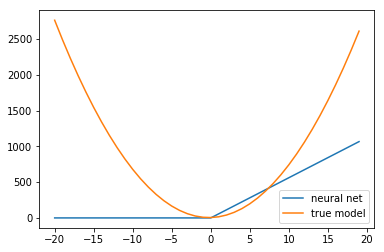

In [20]:
visualize_neural_net(sess, predictions, dim, x_range, degree, c_true)
sess.close()

In [7]:
def create_neural_net(num_layers, layer_widths, num_input, num_output, activation):
    weights = {0: tf.Variable(tf.random_normal([num_input, layer_widths[0]]))}
    for i in range(1, num_layers):
        weights[i] = tf.Variable(tf.random_normal([layer_widths[i-1], layer_widths[i]]))
    weights['out'] = tf.Variable(tf.random_normal([layer_widths[num_layers-1], num_output]))
    
    def net(X):
        net = activation(tf.matmul(X, weights[0]))
        for i in range(1, num_layers):
            net = activation(tf.matmul(net, weights[i]))
        net = activation(tf.matmul(net, weights['out']))
        return net
    return net, weights

def train_nn(sess, net, x_train, y_train, num_steps, learning_rate, display_step, verbose=False):
    predictions = net(X)
    loss = tf.losses.mean_squared_error(Y, predictions, reduction="none")
    mse = tf.losses.mean_squared_error(Y, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(num_steps):
        sess.run(train, feed_dict={X: x_train, Y: y_train})

        if verbose and step < 10 or (step + 1) % display_step == 0 or step == 0:
            print("Step", str(step), "MSE:", sess.run(mse, feed_dict={X: x_train, Y: y_train}))
    
    return predictions, mse

Step 0 MSE: 1.41161e+09
Step 1 MSE: 2.58058e+07
Step 2 MSE: 4.98474e+06
Step 3 MSE: 3.84766e+06
Step 4 MSE: 3.65645e+06
Step 5 MSE: 3.26475e+06
Step 6 MSE: 3.2327e+06
Step 7 MSE: 3.12581e+06
Step 8 MSE: 3.0496e+06
Step 9 MSE: 2.95218e+06
Step 99 MSE: 2.37528e+06
Step 199 MSE: 2.37523e+06
Step 299 MSE: 2.37523e+06
Step 399 MSE: 2.37526e+06
Step 499 MSE: 2.37523e+06
Step 599 MSE: 2.37839e+06
Step 699 MSE: 2.37523e+06
Step 799 MSE: 2.37523e+06
Step 899 MSE: 2.37523e+06
Step 999 MSE: 2.37524e+06
Training error: 2.37524e+06
Testing error: 2.00484e+06


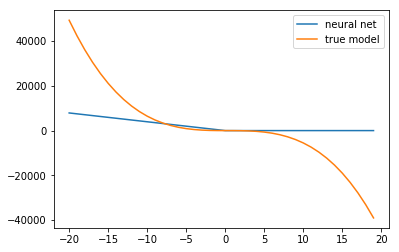

In [17]:
net, weights = create_neural_net(10, [10]*10, 1, 1, tf.nn.relu)
sess = tf.Session()

predictions, mse = train_nn(sess, net, x_train, y_train, num_steps, learning_rate, display_step, verbose=True)
print("Training error:", sess.run(mse, feed_dict={X: x_train, Y: y_train}))
print("Testing error:", sess.run(mse, feed_dict={X: x_test, Y: y_test}))
visualize_neural_net(sess, predictions, dim, x_range, degree, c_true)
sess.close()

In [15]:
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

layer_width = 10
num_input = 1
num_output = 1

X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_output])

weights_4 = {
    'h1': tf.Variable(tf.random_normal([num_input, layer_width])),
    'h2': tf.Variable(tf.random_normal([layer_width, layer_width])),
    'h3': tf.Variable(tf.random_normal([layer_width, layer_width])),
    'h4': tf.Variable(tf.random_normal([layer_width, layer_width])),
    'out': tf.Variable(tf.random_normal([layer_width, num_output]))
}

def neural_net_4(x):
    net = tf.nn.relu(tf.matmul(x, weights_4['h1']))
    net = tf.nn.relu(tf.matmul(net, weights_4['h2']))
    net = tf.nn.relu(tf.matmul(net, weights_4['h3']))
    net = tf.nn.relu(tf.matmul(net, weights_4['h4']))
    net = tf.matmul(net, weights_4['out'])
    return net

predictions_4 = neural_net_4(X)
loss = tf.losses.mean_squared_error(Y, predictions_4, reduction="none")
mse = tf.losses.mean_squared_error(Y, predictions_4)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_4 = optimizer.minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for step in range(num_steps):
    sess.run(train_4, feed_dict={X: x_train, Y: y_train})
    
    if (step + 1) % display_step == 0 or step == 0:
        print("Step", str(step), "MSE:", sess.run(mse, feed_dict={X: x_train, Y: y_train}))

Step 0 MSE: 4.74516e+06
Step 99 MSE: 819632.0
Step 199 MSE: 819628.0
Step 299 MSE: 819628.0
Step 399 MSE: 819628.0
Step 499 MSE: 819628.0
Step 599 MSE: 819628.0
Step 699 MSE: 819628.0
Step 799 MSE: 819628.0
Step 899 MSE: 819628.0
Step 999 MSE: 819628.0


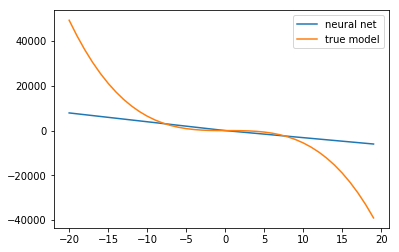

In [16]:
visualize_neural_net(sess, predictions_4, dim, x_range, degree, c_true)